# Business demography of the European Union

## Overview

* This notebook is intended to demonstrate basic techniques of formatting a dataset and gaining simple insights.  The term business demography is used here to cover a group of variables which explain the characteristics and demography of the business population. The creation of new enterprises and the closure of unproductive businesses can be seen as an important contributor to business dynamism. In addition to studying the population of active enterprises, the counts and characteristics of enterprise births and deaths are examined. 

In the following we will apply
* data manipulation using pandas 
* Visualize data using Plotly time-series
* Check correlations between countries
* Visualise with Plotly bar-chart and choropleth




In [17]:
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
import pandas_datareader.data as web

import seaborn as sns
import matplotlib.pyplot as plt

import pycountry
import numpy as np

In [18]:
#UserInfo.tsv
business_demography = pd.read_csv('../datasets/european-business-demography.tsv', delimiter='\t', encoding='utf-8')
#print(list(business_by_demography.columns.values)) #file header
business_demography.columns

Index(['GEO,LEG_FORM,INDIC_SB,NACE_R2\TIME', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015'],
      dtype='object')

### Renaming the lengthy legend

In [19]:
business_demography = business_demography.rename(columns={'GEO,LEG_FORM,INDIC_SB,NACE_R2\TIME':'Countries'})

### Transpose table and generate new vertical index
* Its my personal preference having the growth/death etc. values assigned to each year organized in columns

In [20]:
#Fill empty cells with zeros
business_demography = business_demography.fillna(0)
#Set countries as new dataframe index
business_demography.set_index('Countries',inplace=True)
#Transpose the table
business_demography = business_demography.transpose()

## There are certain flags in the table to indicate special features of the data

### Available flags
* b	break in time series
* c	confidential
* d	definition differs, see metadata
* e	estimated
* f	forecast
* i	see metadata (phased out)
* n	not significant
* p	provisional
* r	revised
* s	Eurostat estimate (phased out)
* u	low reliability
* z	not applicable

It is not recommendable in general to drop the information contained by these flags, but for first exploration purposes it should not do too much harm. The flags can easily remove by filling them all into a list and strip them by looping over this list. 

### Lets remove these flags

In [21]:
flags = ['b', 'c', 'd','e','f','i','n','p','r','s','u','z']

In [22]:
for column in business_demography.columns:  
    column = str(column)
    for flag in flags:
        business_demography[column] = business_demography[column].str.strip(flag)

### Replace the lengthy name of Germany in all availabe columns
1. The lengthy column titles are structered by commas
2. The country name is extracted by using the .split() command with delimiter ','
3. This returns a list of strings where the first element equals the particular country name
4. The name can be replaced

In [23]:
for column in business_demography.columns:  
    column = str(column)
    column_content = column.split(',')[0]
    if 'Germany' in column_content:
        old_german_name = 'Germany (until 1990 former territory of the FRG)'
        new_german_name = 'Germany'
        new_column = column.replace(old_german_name,new_german_name)
        business_demography = business_demography.rename(index=str,columns={column:new_column})

### Replace the colons by zeros and convert strings to numerical values
* The dataset indicates missing data by ':' - lets replace it by zero!
* So far the contained data consists of strings - of course we need numerical values for our exploration.

In [24]:
business_demography = business_demography.replace(':',0)
business_demography =  business_demography.apply(pd.to_numeric, args=('coerce',))
business_demography = business_demography.fillna(0)

### Drop the columns that should contain average data about the EU
* By looking at the raw data you can easily see (of course you can check it as well using pandas) that the columns called 'European Union' contain no data
* Let's drop these columns by using regex, so we get all columns containg 'European Union'!

In [25]:
business_demography.drop(list(business_demography.filter(regex = 'European Union')), axis = 1, inplace = True)

### Drop the years 2006-2008
* Since these years are empty too we can drop them as well!

In [26]:
business_demography = business_demography.drop('2006').drop('2007').drop('2008')

### Last step of preparation: Get all unique country names 
*  it is useful to extract the list of unique countris that are contained in the data

In [27]:
countries_unique = []
for column in business_demography.columns:
    column_content = str(column).split(",")
    countries_unique.append(column_content[0])
countries_unique = list(set(countries_unique))

### Correlations between growth of different legal forms
Plot the correlations of the average 
* Sole proprietorship growth
* Partnership growth
* Limiteds growth
* Total growth in the EU

As can be seen from the plot above, the percentage growth of the enterprises with limited enterprise ist strongly correlated with the total growth in the European Union. The growth of the partnerships, associates etc. is decoupled from the growth of the companies with limited liability. 

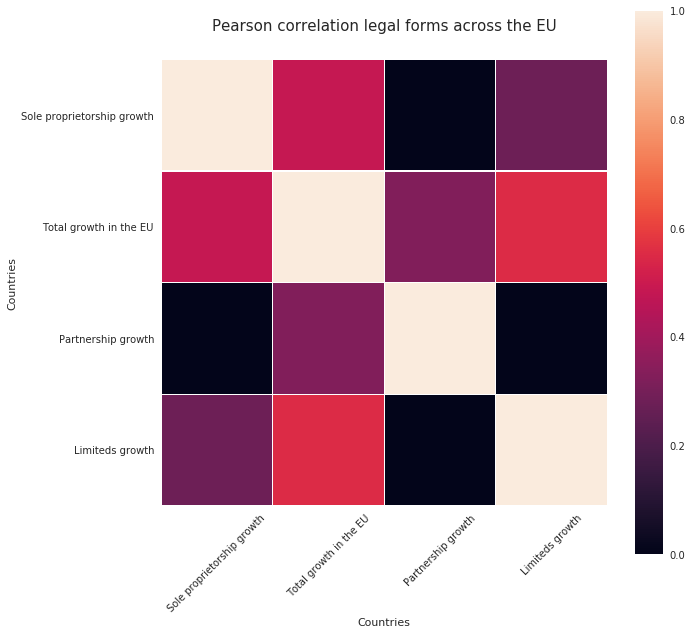

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sole = 'Sole proprietorship growth'
total = 'Total growth in the EU'
partner = 'Partnership growth'
limit = 'Limiteds growth'

business_demography[sole] = business_demography.filter(regex='Sole proprietorship,Net business population growth', axis=1).mean(axis=1)
business_demography[total] = business_demography.filter(regex='Total,Net business population growth', axis=1).mean(axis=1)
business_demography[partner] = business_demography.filter(regex='Partnership, co-operatives, associations, etc.,Net business population growth', axis=1).mean(axis=1)
business_demography[limit] = business_demography.filter(regex='Limited liability enterprise,Net business population growth', axis=1).mean(axis=1)


eu_growth_rates = business_demography.iloc[:,-4:]

plt.figure(figsize=(10,10))
plt.title('Pearson correlation legal forms across the EU', y=1.05, size=15)
plot = sns.heatmap(eu_growth_rates.corr(), xticklabels=eu_growth_rates.columns, yticklabels=eu_growth_rates.columns,  linewidths=0.1,vmax=1.0,vmin=0, square=True, linecolor='white')
#plot.set_xticklabels(plot.get_xticklabels(),rotation=30)
#plot.set_ylabel('')
#plot.set_xlabel('')
plt.setp(plot.get_xticklabels(), rotation=45)
plt.setp(plot.get_yticklabels(), rotation=0)

plt.show()


## Look at the average total net growth of businesses in the EU between 2009 and 2015

* Calculate the average net growth of businesse for each country in the period of measurement 2009-2015
* To visualize the data on a choropleth map the standard country codes are attached to each dataframe entry 
    * Country codes consist of two or three letters: alpha2 and alpha3  --> Read about [alpha3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3)
    * It seems that the plotly choropleth only accepts alpha3 (Probably i have overlooked this in the reference)
    
In the first step we will create a new dataframe where we
* we choose the columns containing 'Total,Net business population growth' 
* map the country name to its corresponding country code
* Calculate the mean of the total growth during the period of measurement 2009 - 2015

/home/chris/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



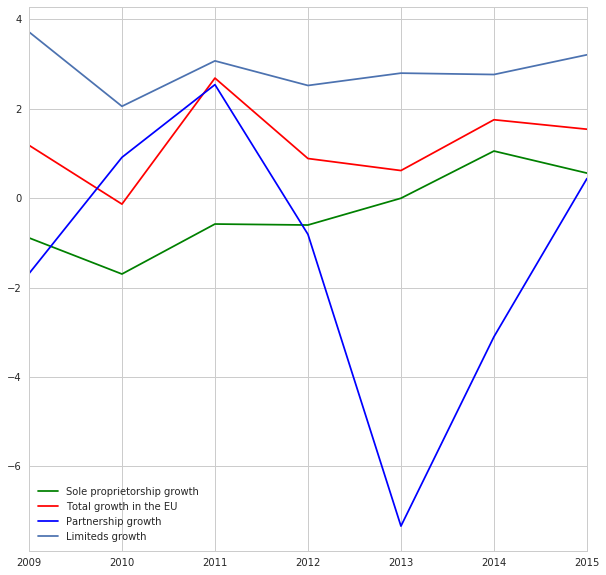

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
sns.set(style="whitegrid")

plt.figure(figsize=(10,10))
# Plot the response with standard error
sns.tsplot(data=business_demography[sole], time=business_demography.index ,condition=sole, legend=True, color='green' )
sns.tsplot(data=business_demography[total], time=business_demography.index ,condition=total, legend=True, color='red' )
sns.tsplot(data=business_demography[partner], time=business_demography.index ,condition=partner, legend=True, color='blue' )
sns.tsplot(data=business_demography[limit], time=business_demography.index ,condition=limit, legend=True )

plt.show()

### Now compare the sources of growth amoung the legal forms

In [30]:
from pycountry import *  
mean_growth_total = []
mean_growth_sole = []
mean_growth_partner = []
mean_growth_limit = []

sole = 'Sole proprietorship,Net business population growth'
total = 'Total,Net business population growth'
partner = 'Partnership, co-operatives, associations, etc.,Net business population growth'
limit = 'Limited liability enterprise,Net business population growth'


for column in business_demography.columns:
    new_column_name = column.split(',')[0]
    if total in column:
        mean_total = business_demography[column].mean()
        mean_growth_total.append([new_column_name, mean_total])
    elif sole in column:
        mean_sole = business_demography[column].mean()
        mean_growth_sole.append(mean_sole)
    elif partner in column:
        mean_partner = business_demography[column].mean()
        mean_growth_partner.append(mean_partner)
    elif limit in column:
        mean_limit = business_demography[column].mean()
        mean_growth_limit.append(mean_limit)
    


join_lists = [mean_growth_total, mean_growth_sole, mean_growth_partner, mean_growth_limit]
columns = ['Country', 'Total_mean_growth','Sole_proprietor_mean_growth', 'Partnerships_mean_growth', 'Limited_liability_mean_growth']

mean_growth_country = pd.DataFrame(np.column_stack(join_lists), columns=columns)
mean_growth_country.iloc[:,1:] = mean_growth_country.iloc[:,1:].apply(pd.to_numeric, args=('coerce',))

## Now we can plot `mean_growth_country` as a Seabron bar chart.

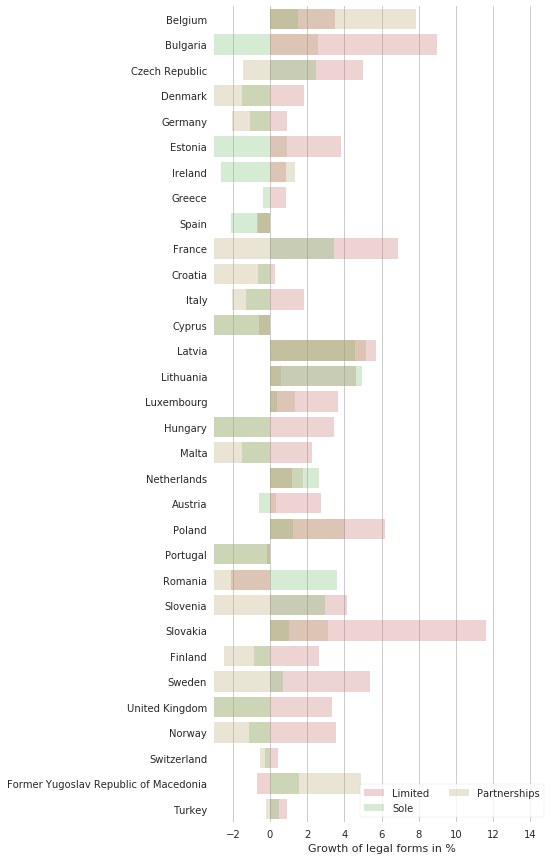

In [35]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Limited_liability_mean_growth", y="Country", data=mean_growth_country,
            label="Limited", color="r", alpha=0.3)
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Sole_proprietor_mean_growth", y="Country", data=mean_growth_country,
            label="Sole", color="g", alpha=0.3)

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="Partnerships_mean_growth", y="Country", data=mean_growth_country,
            label="Partnerships", color="y", alpha=0.3)


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(-3, 15), ylabel="",
       xlabel="Growth of legal forms in %")
sns.despine(left=True, bottom=True)

plt.show()

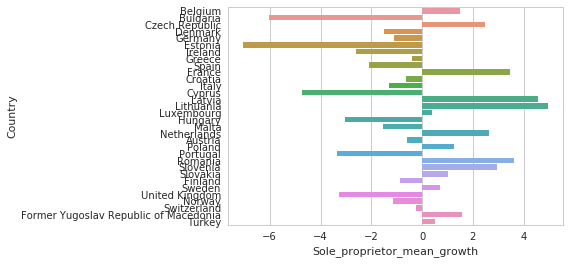

In [38]:
sns.barplot(x="Sole_proprietor_mean_growth", y="Country", data=mean_growth_country)
plt.show()

### Conclusion
The dominating sources for the total growth of the business population are France, the Benelux states as well as a number eastern european Countries. The explored data was taken during 2009 and 2015. A dominating and stable source for growth of the business population are the enterprises with limited liability .